In [1]:
# ============================================================
#  CELL 1: Imports
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization import PercentileInterval, AsinhStretch, ImageNormalize
import astropy.units as u

from scipy.ndimage import gaussian_filter, binary_dilation, label


# ============================================================
#  CELL 2: Configuration
# ============================================================

# Datasets and paths
DATASETS = ["23", "25", "32", "36"]

TRUE_DET_PATH = "../paper2/total/true_detections_full.csv"
OUT_CSV_PATH  = "../paper2/total/true_detections_with_diffuse_flag.csv"

# Background P images (same ones used to define masks)
P_FITS_TEMPLATE = "../../BDSF4/{ds}_background.fits"

# Default mask parameters (fill with your preferred / old defaults)
DEFAULT_PARAMS = dict(
    smooth_sigma=40.0,
    perc=93.0,
    grow_pixels=8,
    min_region_pixels=1200,
)

# Dataset-specific parameters
DATASET_PARAMS = {
    # 23 and 36 use the wider *default* settings
    "23": DEFAULT_PARAMS,
    "36": DEFAULT_PARAMS,

    # 25: make the mask a bit wider than default
    "25": dict(
        smooth_sigma=45.0,     # more smoothing than default 40
        perc=92.0,             # slightly lower percentile (was 93)
        grow_pixels=10,        # grow more (was 8)
        min_region_pixels=1100 # keep slightly smaller regions
    ),

    # 32: broad, strong Galactic diffuse emission (already wide)
    "32": dict(
        smooth_sigma=60.0,
        perc=85.0,
        grow_pixels=12,
        min_region_pixels=800,
    ),
}

# RA/DEC column names in the true detections catalog
RA_COL  = "RA"
DEC_COL = "DEC"

# Columns needed to compute polarized intensity of the source:
# P_src = (fracPol_percent / 100) * I_freq0
FRACPOL_COL = "fracPol"   # <-- change if needed
I_FREQ_COL  = "S_reffreq"       # <-- change if needed
P_SRC_COL   = "P_src"         # new column we will create

CONTOUR_FILL_ALPHA  = 0.45
CONTOUR_EDGEWIDTH   = 2.0
CONTOUR_COLOR       = "white"


# ============================================================
#  CELL 3: Helper functions – mask building
# ============================================================

def remove_small_regions(mask, min_pixels):
    """
    Remove connected regions smaller than min_pixels.
    Keeps only large-scale diffuse structures.
    """
    labeled, nlab = label(mask)
    print(f"[cleanup] found {nlab} connected regions")

    clean = np.zeros_like(mask, dtype=bool)

    for i in range(1, nlab + 1):
        comp = (labeled == i)
        npix = comp.sum()
        if npix >= min_pixels:
            clean |= comp
        else:
            print(f"[cleanup] removing region {i} ({npix} pixels)")

    print(f"[cleanup] remaining pixels = {clean.sum()}")
    return clean


def build_diffuse_region_from_P(data,
                                smooth_sigma,
                                perc,
                                grow_pixels,
                                min_region_pixels):
    """
    Build a smooth diffuse-region mask directly from the P image.
    Returns: (clean_region_bool, smooth_map)
    """
    finite = np.isfinite(data)
    if not np.any(finite):
        raise RuntimeError("No finite pixels in data!")

    vals = data[finite]
    med_val = np.nanmedian(vals)

    # Fill non-finite values with median
    data_filled = np.where(finite, data, med_val)

    # Heavy smoothing
    smooth = gaussian_filter(data_filled, sigma=smooth_sigma, mode="nearest")

    # Threshold on smoothed map via percentile
    smooth_finite = smooth[finite]
    thr = np.nanpercentile(smooth_finite, perc)
    base_region = (smooth >= thr) & finite

    print(f"[build] smooth_sigma={smooth_sigma}, perc={perc}")
    print(f"[build] threshold (smoothed P) = {thr:.3e}")
    print(f"[build] base diffuse-region pixels = {base_region.sum()}")

    # Grow / widen the mask
    if grow_pixels > 0:
        struct = np.ones((3, 3), dtype=bool)
        grown_region = binary_dilation(base_region, structure=struct,
                                       iterations=grow_pixels)
        print(f"[build] grown diffuse-region pixels  = {grown_region.sum()} "
              f"(after {grow_pixels} dilations)")
    else:
        grown_region = base_region

    # Remove small islands
    clean_region = remove_small_regions(grown_region,
                                        min_pixels=min_region_pixels)
    print(f"[build] final diffuse-region pixels = {clean_region.sum()}")

    return clean_region, smooth


def compute_max_P_in_mask(data, mask_bool):
    """
    Compute maximum value of 'data' within mask_bool.
    Returns np.nan if mask has no True pixels.
    """
    if mask_bool.sum() == 0:
        print("[maxP] WARNING: mask has zero pixels; returning NaN")
        return np.nan

    masked_vals = data[mask_bool & np.isfinite(data)]
    if masked_vals.size == 0:
        print("[maxP] WARNING: mask has no finite pixels; returning NaN")
        return np.nan

    max_val = np.nanmax(masked_vals)
    print(f"[maxP] max P value in mask = {max_val:.3e}")
    return max_val


# ============================================================
#  CELL 4: Plotting helpers
# ============================================================

def quicklook_plot_diffuse_from_P(ds, data, region_bool, wcs_cel, outpath):
    finite = np.isfinite(data)
    if np.any(finite):
        interval = PercentileInterval(99.5)
        vmin, vmax = interval.get_limits(data[finite])
    else:
        vmin, vmax = np.nanmin(data), np.nanmax(data)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=AsinhStretch())

    region_float = np.where(region_bool, 1.0, np.nan)
    print(f"[plot] diffuse-region pixels = {region_bool.sum()}")

    fig = plt.figure(figsize=(10, 4))

    # Left: P image
    ax1 = fig.add_subplot(1, 2, 1, projection=wcs_cel)
    im1 = ax1.imshow(data, origin="lower", norm=norm)
    ax1.set_title(f"{ds}P")
    ax1.set_xlabel("RA (J2000)")
    ax1.set_ylabel("Dec (J2000)")
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label("P")

    # Right: P + diffuse overlay
    ax2 = fig.add_subplot(1, 2, 2, projection=wcs_cel)
    im2 = ax2.imshow(data, origin="lower", norm=norm)

    ax2.contourf(
        region_float,
        levels=[0.5, 1.5],
        colors=[CONTOUR_COLOR],
        alpha=CONTOUR_FILL_ALPHA,
    )
    ax2.contour(
        region_float,
        levels=[0.5],
        colors=[CONTOUR_COLOR],
        linewidths=CONTOUR_EDGEWIDTH,
    )

    ax2.set_title(f"{ds}P + smooth diffuse mask")
    ax2.set_xlabel("RA (J2000)")
    ax2.set_ylabel("Dec (J2000)")
    cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    cbar2.set_label("P")

    patch = mpatches.Patch(color=CONTOUR_COLOR,
                           alpha=CONTOUR_FILL_ALPHA,
                           label="Diffuse region")
    ax2.legend(handles=[patch], loc="lower left", fontsize="small")

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close(fig)
    print(f"Saved P+mask plot to: {outpath}")


def save_mask_only(ds, region_bool, wcs_cel, outpath):
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection=wcs_cel)

    mask_float = np.where(region_bool, 1.0, 0.0)

    im = ax.imshow(
        mask_float,
        origin="lower",
        cmap="gray",
        vmin=0,
        vmax=1,
    )

    ax.set_title(f"{ds} diffuse mask (binary)")
    ax.set_xlabel("RA (J2000)")
    ax.set_ylabel("Dec (J2000)")

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Diffuse mask")

    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.close(fig)
    print(f"Saved MASK-only image to: {outpath}")


# ============================================================
#  CELL 5: Build all masks and store their properties
# ============================================================

def build_masks_for_all_datasets():
    """
    Build diffuse masks, compute max P in each mask, and
    return a dictionary:
        MASKS[ds] = {
            'mask':  region_bool,
            'wcs':   wcs_cel,
            'max_P': max_P_in_mask
        }
    """
    masks_dict = {}

    for ds in DATASETS:
        print("\n" + "=" * 60)
        print(f"Processing dataset {ds}")
        print("=" * 60)

        params = DATASET_PARAMS.get(ds, DEFAULT_PARAMS)
        print(f"[params] using: {params}")

        fits_path = P_FITS_TEMPLATE.format(ds=ds)

        with fits.open(fits_path) as hdul:
            data_full = hdul[0].data
            wcs_full  = WCS(hdul[0].header)

        data    = data_full.squeeze()
        wcs_cel = wcs_full.celestial
        print("Data shape:", data.shape)

        # Build diffuse region
        region_bool, smooth_map = build_diffuse_region_from_P(
            data,
            smooth_sigma=params["smooth_sigma"],
            perc=params["perc"],
            grow_pixels=params["grow_pixels"],
            min_region_pixels=params["min_region_pixels"],
        )

        # Compute maximum P value inside the mask
        max_P = compute_max_P_in_mask(data, region_bool)

        # Save mask info
        masks_dict[ds] = {
            "mask":  region_bool,
            "wcs":   wcs_cel,
            "max_P": max_P
        }

        # P + mask overlay
        out_overlay = f"../server/total/{ds}P_diffuse_smooth_clean.png"
        quicklook_plot_diffuse_from_P(ds, data, region_bool, wcs_cel, out_overlay)

        # Mask-only diagnostic
        out_mask = f"../server/total/{ds}P_diffuse_mask_ONLY_clean.png"
        save_mask_only(ds, region_bool, wcs_cel, out_mask)

        print(f"Finished dataset {ds}")

    return masks_dict


# ============================================================
#  CELL 6: Compute polarized intensity for each source
# ============================================================

def add_polarized_intensity_column(df):
    """
    Compute polarized intensity P_src from fracPol and S_reffreq:

        If fracPol is in percent:
            P_src = (fracPol / 100) * S_reffreq

        If fracPol is already a fraction (0–1), then remove the / 100.0
        below.

    and add as a new column P_SRC_COL.
    """
    if FRACPOL_COL not in df.columns:
        raise KeyError(f"Column '{FRACPOL_COL}' not found in catalog. "
                       f"Available columns: {list(df.columns)}")
    if I_FREQ_COL not in df.columns:
        raise KeyError(f"Column '{I_FREQ_COL}' not found in catalog. "
                       f"Available columns: {list(df.columns)}")

    frac = df[FRACPOL_COL].astype(float)   # assumed in %
    Ival = df[I_FREQ_COL].astype(float)

    # If fracPol is in percent:
    df[P_SRC_COL] = (frac / 100.0) * Ival

    # If instead fracPol is already 0–1, use this line instead:
    # df[P_SRC_COL] = frac * Ival

    print(f"[P_src] Added column '{P_SRC_COL}' for polarized intensity.")
    return df



# ============================================================
#  CELL 7: Flag computation (0, 1, 2)
# ============================================================

def diffuse_flag_for_source(ra_deg, dec_deg, p_src, masks_dict):
    """
    Compute diffuse flag for a single source:
      0: outside all diffuse masks
      1: inside at least one diffuse mask
      2: inside at least one diffuse mask AND p_src > 2 * max_P_in_that_mask
    We check all datasets; if any dataset gives flag 2, we return 2.
    """
    if not np.isfinite(ra_deg) or not np.isfinite(dec_deg):
        return 0

    sc = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg)
    flag = 0  # start assuming outside all diffuse regions

    for ds, info in masks_dict.items():
        mask_bool = info["mask"]
        wcs_cel   = info["wcs"]
        max_P     = info["max_P"]

        # Convert RA/Dec → pixel in this dataset
        xpix, ypix = skycoord_to_pixel(sc, wcs_cel)
        j = int(np.round(xpix))  # column
        i = int(np.round(ypix))  # row

        ny, nx = mask_bool.shape
        if i < 0 or i >= ny or j < 0 or j >= nx:
            # Outside this image
            continue

        if mask_bool[i, j]:
            # Inside the diffuse region for this dataset
            flag = max(flag, 1)  # at least 1 now

            # Check "extremely bright vs diffuse background"
            if np.isfinite(p_src) and np.isfinite(max_P) and (p_src > 2.0 * max_P):
                # As soon as we find one dataset where source is > 2×max_P, set flag 2
                return 2

    return flag


def compute_flags_for_all_sources(df, masks_dict):
    """
    Compute InDiffuseMask for all rows in df using RA, DEC and P_src.
    """
    if RA_COL not in df.columns or DEC_COL not in df.columns:
        raise ValueError(f"Expected columns '{RA_COL}' and '{DEC_COL}' in catalog, "
                         f"but did not find them.")

    if P_SRC_COL not in df.columns:
        raise ValueError(f"Expected column '{P_SRC_COL}' (polarized intensity). "
                         "Call add_polarized_intensity_column(df) first.")

    flags = []

    for idx, row in df.iterrows():
        ra  = row[RA_COL]
        dec = row[DEC_COL]
        p   = row[P_SRC_COL]

        flag = diffuse_flag_for_source(ra, dec, p, masks_dict)
        flags.append(flag)

        if (idx + 1) % 1000 == 0:
            print(f"  processed {idx + 1} sources...")

    df["InDiffuseMask"] = flags
    print("\n[flags] Number of sources with flag = 1 or 2:",
          np.sum((df["InDiffuseMask"] == 1) | (df["InDiffuseMask"] == 2)))
    print("[flags] Number of sources with flag = 2:",
          np.sum(df["InDiffuseMask"] == 2))
    print("[flags] Total number of sources:", len(df))

    return df


# ============================================================
#  CELL 8: Main script
# ============================================================

if __name__ == "__main__":

    # 1) Build masks (and diagnostic figures) for all datasets
    MASKS = build_masks_for_all_datasets()

    # 2) Read true detections catalog
    print("\nReading true detections catalog...")
    df = pd.read_csv(TRUE_DET_PATH)
    print("Columns:", df.columns.tolist())
    print("Total sources in catalog:", len(df))

    # 3) Add polarized intensity column P_src
    df = add_polarized_intensity_column(df)

    # 4) Compute InDiffuseMask = 0/1/2
    print("\nComputing InDiffuseMask flag (0, 1, 2) for each source...")
    df = compute_flags_for_all_sources(df, MASKS)

    # 5) Save output
    df.to_csv(OUT_CSV_PATH, index=False)
    print("\nSaved catalog with diffuse flags to:")
    print(" ", OUT_CSV_PATH)



Processing dataset 23
[params] using: {'smooth_sigma': 40.0, 'perc': 93.0, 'grow_pixels': 8, 'min_region_pixels': 1200}
Data shape: (4096, 4096)


  'HZ' -> 'Hz'. [astropy.wcs.wcs]


[build] smooth_sigma=40.0, perc=93.0
[build] threshold (smoothed P) = 1.181e-04
[build] base diffuse-region pixels = 588228
[build] grown diffuse-region pixels  = 736730 (after 8 dilations)
[cleanup] found 18 connected regions
[cleanup] removing region 8 (772 pixels)
[cleanup] remaining pixels = 735958
[build] final diffuse-region pixels = 735958
[maxP] max P value in mask = 4.776e-04
[plot] diffuse-region pixels = 735958
Saved P+mask plot to: ../server/total/23P_diffuse_smooth_clean.png
Saved MASK-only image to: ../server/total/23P_diffuse_mask_ONLY_clean.png
Finished dataset 23

Processing dataset 25
[params] using: {'smooth_sigma': 45.0, 'perc': 92.0, 'grow_pixels': 10, 'min_region_pixels': 1100}
Data shape: (4096, 4096)


  'HZ' -> 'Hz'. [astropy.wcs.wcs]


[build] smooth_sigma=45.0, perc=92.0
[build] threshold (smoothed P) = 9.638e-05
[build] base diffuse-region pixels = 671697
[build] grown diffuse-region pixels  = 828374 (after 10 dilations)
[cleanup] found 19 connected regions
[cleanup] removing region 8 (885 pixels)
[cleanup] remaining pixels = 827489
[build] final diffuse-region pixels = 827489
[maxP] max P value in mask = 3.311e-04
[plot] diffuse-region pixels = 827489
Saved P+mask plot to: ../server/total/25P_diffuse_smooth_clean.png
Saved MASK-only image to: ../server/total/25P_diffuse_mask_ONLY_clean.png
Finished dataset 25

Processing dataset 32
[params] using: {'smooth_sigma': 60.0, 'perc': 85.0, 'grow_pixels': 12, 'min_region_pixels': 800}
Data shape: (4096, 4096)


  'HZ' -> 'Hz'. [astropy.wcs.wcs]


[build] smooth_sigma=60.0, perc=85.0
[build] threshold (smoothed P) = 9.547e-05
[build] base diffuse-region pixels = 1256881
[build] grown diffuse-region pixels  = 1417385 (after 12 dilations)
[cleanup] found 5 connected regions
[cleanup] remaining pixels = 1417385
[build] final diffuse-region pixels = 1417385
[maxP] max P value in mask = 4.272e-04
[plot] diffuse-region pixels = 1417385
Saved P+mask plot to: ../server/total/32P_diffuse_smooth_clean.png
Saved MASK-only image to: ../server/total/32P_diffuse_mask_ONLY_clean.png
Finished dataset 32

Processing dataset 36
[params] using: {'smooth_sigma': 40.0, 'perc': 93.0, 'grow_pixels': 8, 'min_region_pixels': 1200}
Data shape: (4096, 4096)


  'HZ' -> 'Hz'. [astropy.wcs.wcs]


[build] smooth_sigma=40.0, perc=93.0
[build] threshold (smoothed P) = 1.175e-04
[build] base diffuse-region pixels = 588244
[build] grown diffuse-region pixels  = 740722 (after 8 dilations)
[cleanup] found 29 connected regions
[cleanup] removing region 8 (1139 pixels)
[cleanup] removing region 17 (543 pixels)
[cleanup] remaining pixels = 739040
[build] final diffuse-region pixels = 739040
[maxP] max P value in mask = 5.795e-04
[plot] diffuse-region pixels = 739040
Saved P+mask plot to: ../server/total/36P_diffuse_smooth_clean.png
Saved MASK-only image to: ../server/total/36P_diffuse_mask_ONLY_clean.png
Finished dataset 36

Reading true detections catalog...
Columns: ['Source_ID', 'RA', 'E_RA', 'DEC', 'E_DEC', 'RM', 'E_RM', 'RMS', 'Threshold', 'ampPeakPIfit', 'fracPol', 'S_reffreq', 'Dataset']
Total sources in catalog: 206
[P_src] Added column 'P_src' for polarized intensity.

Computing InDiffuseMask flag (0, 1, 2) for each source...

[flags] Number of sources with flag = 1 or 2: 43
[fl

Total sources          : 206
Flag = 0 (outside)     : 163
Flag = 1 (in diffuse)  : 39
Flag = 2 (bright diff): 4


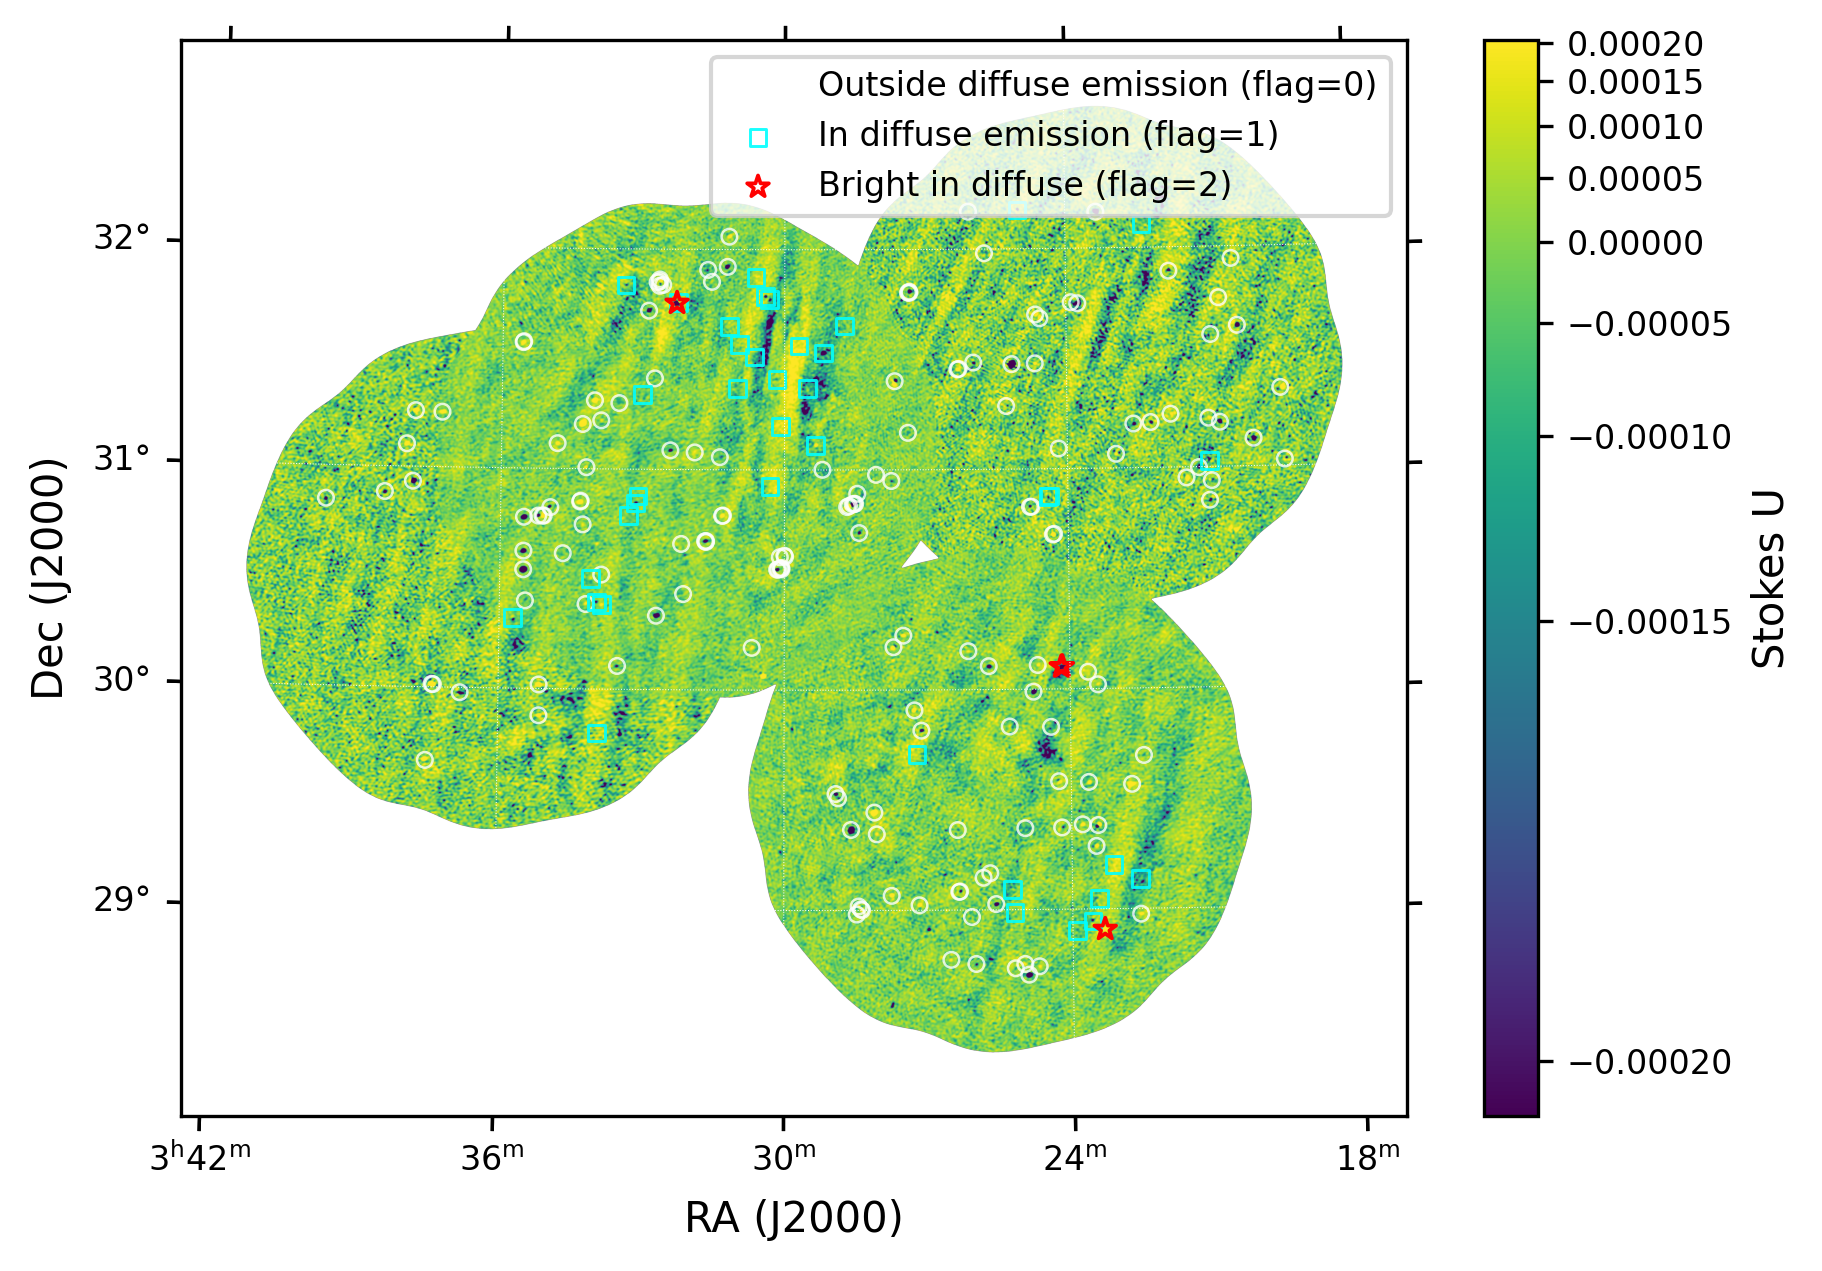

Saved: ../server/total/Total_StokesU_flags012_sources_soft.pdf


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import (
    ImageNormalize,
    AsinhStretch,
    PercentileInterval
)
from astropy.coordinates import SkyCoord
import astropy.units as u

from scipy.ndimage import gaussian_filter


# =========================
# Paths
# =========================
STOKESU_FITS = "../server/total/combined_result_U.fits"
CATALOG_PATH = "../paper2/total/true_detections_with_diffuse_flag.csv"
OUT_MAP      = "../server/total/Total_StokesU_flags012_sources_soft.pdf"


# =========================
# Load catalog
# =========================
df = pd.read_csv(CATALOG_PATH)

RA_COL   = "RA"
DEC_COL  = "DEC"
FLAG_COL = "InDiffuseMask"

if FLAG_COL not in df.columns:
    raise KeyError(f"Column '{FLAG_COL}' not found in catalog. "
                   f"Available columns: {list(df.columns)}")

df0 = df[df[FLAG_COL] == 0].copy()  # outside diffuse
df1 = df[df[FLAG_COL] == 1].copy()  # in diffuse
df2 = df[df[FLAG_COL] == 2].copy()  # in diffuse & very bright

print(f"Total sources          : {len(df)}")
print(f"Flag = 0 (outside)     : {len(df0)}")
print(f"Flag = 1 (in diffuse)  : {len(df1)}")
print(f"Flag = 2 (bright diff): {len(df2)}")


# =========================
# Load Stokes U image
# =========================
hdu  = fits.open(STOKESU_FITS)[0]
data = hdu.data.squeeze()
wcs  = WCS(hdu.header)

finite = np.isfinite(data)
vals   = data[finite]

# ---------------------------------
# LOW-CONTRAST, SYMMETRIC SCALING
# ---------------------------------
p = np.nanpercentile(np.abs(vals), 99)   # compress extremes gently

vmin = -p
vmax = +p

norm = ImageNormalize(
    vmin=vmin,
    vmax=vmax,
    stretch=AsinhStretch(a=0.05)   # very gentle
)


# ---------------------------------
# OPTIONAL: visual-only smoothing
# (does NOT affect data analysis)
# ---------------------------------
data_plot = gaussian_filter(data, sigma=1.0)  # smooth appearance


# =========================
# Sky coordinates per flag
# =========================
coords0 = SkyCoord(
    ra=df0[RA_COL].values * u.deg,
    dec=df0[DEC_COL].values * u.deg,
    frame="icrs"
)

coords1 = SkyCoord(
    ra=df1[RA_COL].values * u.deg,
    dec=df1[DEC_COL].values * u.deg,
    frame="icrs"
)

coords2 = SkyCoord(
    ra=df2[RA_COL].values * u.deg,
    dec=df2[DEC_COL].values * u.deg,
    frame="icrs"
)


# =========================
# Plot
# =========================
fig = plt.figure(figsize=(6.2, 5.2), dpi=300)
ax = plt.subplot(projection=wcs)

im = ax.imshow(
    data_plot,
    origin="lower",
    cmap="viridis",
    norm=norm
)

# --- Flag = 0: outside diffuse emission (soft white circles)
if len(df0) > 0:
    ax.scatter(
        coords0.ra.deg,
        coords0.dec.deg,
        transform=ax.get_transform("world"),
        s=14,
        facecolors="none",
        edgecolors="white",
        linewidths=0.6,
        alpha=0.8,
        label="Outside diffuse emission (flag=0)"
    )

# --- Flag = 1: in diffuse emission (soft cyan squares)
if len(df1) > 0:
    ax.scatter(
        coords1.ra.deg,
        coords1.dec.deg,
        transform=ax.get_transform("world"),
        s=16,
        marker="s",
        facecolors="none",
        edgecolors="cyan",
        linewidths=0.7,
        alpha=0.9,
        label="In diffuse emission (flag=1)"
    )

# --- Flag = 2: very bright in diffuse (highlight with star markers)
if len(df2) > 0:
    ax.scatter(
        coords2.ra.deg,
        coords2.dec.deg,
        transform=ax.get_transform("world"),
        s=30,
        marker="*",
        facecolors="none",
        edgecolors="red",
        linewidths=0.9,
        alpha=1.0,
        label="Bright in diffuse (flag=2)"
    )

# Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.05, shrink=0.8)
cbar.set_label("Stokes U", fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Labels and grid
ax.set_xlabel("RA (J2000)", fontsize=10)
ax.set_ylabel("Dec (J2000)", fontsize=10)
ax.coords.grid(color="white", linestyle=":", linewidth=0.25)
ax.tick_params(labelsize=8)

ax.legend(loc="upper right", fontsize=8, frameon=True)

plt.tight_layout()
plt.savefig(OUT_MAP, dpi=600, bbox_inches="tight")
plt.show()

print("Saved:", OUT_MAP)


# Double Peak

In [3]:
import re
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

# ============================================================
# Paths
# ============================================================
CATALOG_PATH = "../paper2/total/true_detections_with_diffuse_flag.csv"
OUT_PATH     = "../paper2/total/true_detections_with_diffuse_flag.csv"

# This is the file you created that contains one H+RA+DEC per line
DOUBLE_PEAK_TXT = "../paper2/total/double_peak_sources_H.txt"

# ============================================================
# Read double-peak H-names from file
# ============================================================
# Accepts lines like:
# H+50.01252+31.12604
# H+52.51526-30.54888
H_PATTERN = re.compile(r"^H\+([0-9]+(?:\.[0-9]+)?)([+-][0-9]+(?:\.[0-9]+)?)$")

dp_ra, dp_dec = [], []

with open(DOUBLE_PEAK_TXT, "r") as f:
    for line in f:
        s = line.strip()
        if not s or s.startswith("#"):
            continue

        m = H_PATTERN.match(s)
        if not m:
            # skip anything that doesn't match cleanly
            continue

        dp_ra.append(float(m.group(1)))
        dp_dec.append(float(m.group(2)))

if len(dp_ra) == 0:
    raise ValueError(f"No valid H+RA+DEC names found in: {DOUBLE_PEAK_TXT}")

double_peak_coords = SkyCoord(ra=np.array(dp_ra) * u.deg,
                              dec=np.array(dp_dec) * u.deg,
                              frame="icrs")

# ============================================================
# Load catalog
# ============================================================
df = pd.read_csv(CATALOG_PATH)
df.columns = df.columns.str.strip()

if "RA" not in df.columns or "DEC" not in df.columns:
    raise ValueError("Catalog must contain 'RA' and 'DEC' columns")

catalog_coords = SkyCoord(ra=df["RA"].values * u.deg,
                          dec=df["DEC"].values * u.deg,
                          frame="icrs")

# ============================================================
# Match sources & assign DoublePeak flag
# ============================================================
MATCH_RADIUS = 2.0 * u.arcsec  # conservative, safe

# Vectorized nearest-neighbor match
idx, sep2d, _ = double_peak_coords.match_to_catalog_sky(catalog_coords)
good = sep2d < MATCH_RADIUS

double_peak_flag = np.zeros(len(df), dtype=int)
double_peak_flag[idx[good]] = 1

df["DoublePeak"] = double_peak_flag

print("Double-peak list size (parsed):", len(double_peak_coords))
print(f"Matched within {MATCH_RADIUS}:", int(good.sum()))
print("Number of double-peaked sources in catalog:", int(df["DoublePeak"].sum()))

# ============================================================
# Save (overwrite same file)
# ============================================================
df.to_csv(OUT_PATH, index=False)
print("Updated catalog saved to:")
print(" ", OUT_PATH)


Double-peak list size (parsed): 42
Matched within 2.0 arcsec: 37
Number of double-peaked sources in catalog: 37
Updated catalog saved to:
  ../paper2/total/true_detections_with_diffuse_flag.csv


# Big clean table

In [10]:
import pandas as pd
from pathlib import Path

# ======================================
# Paths
# ======================================
base_dir    = Path("../paper2/total/")
input_path  = base_dir / "true_detections_with_diffuse_flag.csv"
output_path = base_dir / "true_detections_final.csv"

# ======================================
# Read input catalog
# ======================================
df = pd.read_csv(input_path)

# Strip whitespace from column names
df.columns = df.columns.str.strip()

print("Columns in file:")
print(df.columns.tolist())

# ======================================
# Map lowercase -> actual column name
# ======================================
lower_map = {c.lower(): c for c in df.columns}

src_col   = lower_map.get("source_id",    None)
ra_col    = lower_map.get("ra",           None)
era_col   = lower_map.get("e_ra",         None)
dec_col   = lower_map.get("dec",          None)
edec_col  = lower_map.get("e_dec",        None)
rm_col    = lower_map.get("rm",           None)
erm_col   = lower_map.get("e_rm",         None)
rms_col   = lower_map.get("rms",          None)
frac_col  = lower_map.get("fracpol",      None)
sref_col  = lower_map.get("s_reffreq",    None)
f1_src    = lower_map.get("indiffusemask", None)
f2_src    = lower_map.get("doublepeak",    None)

# Build desired columns from what actually exists
col_order = []
for c in [src_col, ra_col, era_col, dec_col, edec_col,
          rm_col, erm_col, rms_col, frac_col, sref_col,
          f1_src, f2_src]:
    if c is not None and c in df.columns:
        col_order.append(c)

missing_logical = []
logical_names = {
    "Source_ID": src_col,
    "RA": ra_col,
    "E_RA": era_col,
    "DEC": dec_col,
    "E_DEC": edec_col,
    "RM": rm_col,
    "E_RM": erm_col,
    "RMS": rms_col,
    "fracPol": frac_col,
    "S_reffreq": sref_col,
    "InDiffuseMask": f1_src,
    "DoublePeak": f2_src,
}
for logical, actual in logical_names.items():
    if actual is None:
        missing_logical.append(logical)

if missing_logical:
    print("⚠️ These logical columns were not matched in the file (check spelling/case):")
    print(missing_logical)

# ======================================
# Select and copy final columns
# ======================================
df_final = df[col_order].copy()

# Rename to final names: F1 / F2 and canonical names for others
rename_map = {}
if src_col:  rename_map[src_col]  = "Source_ID"
if ra_col:   rename_map[ra_col]   = "RA"
if era_col:  rename_map[era_col]  = "E_RA"
if dec_col:  rename_map[dec_col]  = "DEC"
if edec_col: rename_map[edec_col] = "E_DEC"
if rm_col:   rename_map[rm_col]   = "RM"
if erm_col:  rename_map[erm_col]  = "E_RM"
if rms_col:  rename_map[rms_col]  = "RMS"
if frac_col: rename_map[frac_col] = "fracPol"
if sref_col: rename_map[sref_col] = "S_reffreq"
if f1_src:   rename_map[f1_src]   = "F1"
if f2_src:   rename_map[f2_src]   = "F2"

df_final = df_final.rename(columns=rename_map)

# Sort if Source_ID exists
if "Source_ID" in df_final.columns:
    df_final = df_final.sort_values("Source_ID")

# ======================================
# Save final cleaned catalog
# ======================================
df_final.to_csv(output_path, index=False)
print(f"✅ Final cleaned catalog saved to: {output_path}")
print("Final columns:", df_final.columns.tolist())


Columns in file:
['Source_ID', 'RA', 'E_RA', 'DEC', 'E_DEC', 'RM', 'E_RM', 'RMS', 'Threshold', 'ampPeakPIfit', 'fracPol', 'S_reffreq', 'Dataset', 'P_src', 'InDiffuseMask', 'DoublePeak']
✅ Final cleaned catalog saved to: ../paper2/total/true_detections_final.csv
Final columns: ['Source_ID', 'RA', 'E_RA', 'DEC', 'E_DEC', 'RM', 'E_RM', 'RMS', 'fracPol', 'S_reffreq', 'F1', 'F2']


# Revise table if needed

In [11]:
import pandas as pd
from pathlib import Path

# ======================================
# Path
# ======================================
base_dir = Path("../paper2/total")
output_path = base_dir / "true_detections_final.csv"

# ======================================
# Load CSV
# ======================================
df = pd.read_csv(output_path)
df.columns = df.columns.str.strip()

# ======================================
# Checks
# ======================================
if "fracPol" not in df.columns:
    raise ValueError("Column 'fracPol' not found in the file")

# Create F1 if it does not exist
if "F1" not in df.columns:
    df["F1"] = 0

initial_n = len(df)

# ======================================
# Step 1: REMOVE fracPol > 50
# ======================================
df = df[df["fracPol"] <= 50].copy()
removed_n = initial_n - len(df)

# ======================================
# Step 2: FLAG 40 < fracPol ≤ 50 → F1 = 1
# ======================================
mask_40_50 = (df["fracPol"] > 40) & (df["fracPol"] <= 50)
df.loc[mask_40_50, "F1"] = 1

# ======================================
# Save (overwrite)
# ======================================
df.to_csv(output_path, index=False)

# ======================================
# Report
# ======================================
print(f"Initial rows             : {initial_n}")
print(f"Removed (fracPol > 50)   : {removed_n}")
print(f"Flagged (40–50%) F1 = 1  : {mask_40_50.sum()}")
print(f"Remaining rows           : {len(df)}")
print(f"Updated file saved to    : {output_path}")


Initial rows             : 206
Removed (fracPol > 50)   : 1
Flagged (40–50%) F1 = 1  : 1
Remaining rows           : 205
Updated file saved to    : ../paper2/total/true_detections_final.csv
